In [1]:
#from ib_insync import *
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels import regression,stats
import math
import datetime 
import statsmodels.formula.api as smf 
from datetime import date, time, datetime, timedelta
from collections import deque
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from operator import itemgetter 

In [2]:
def get_ratio(country, adr, fx_dict):
    adr_path = f'eric_jh_data/{country}/{adr}/adr.csv'
    stock_path =  f'eric_jh_data/{country}/{adr}/underlying.csv'
    fx_path = fx_dict[country][0]
    fx_type =  fx_dict[country][1]

    adr_df = pd.read_csv(adr_path, index_col = 0).rename(columns = {'close':'adr_close', 'open':'adr_open'})
    stock_df = pd.read_csv(stock_path, index_col = 0).rename(columns = {'close':'stock_close', 'open':'stock_open'})
    fx_df = pd.read_csv(fx_path, index_col = 0)

    merged_df = pd.merge(adr_df.loc[:,['date', 'adr_open','adr_close']], stock_df.loc[:,['date', 'stock_open','stock_close']])
    merged_df = pd.merge(merged_df, fx_df)

    if fx_type == 1:
        merged_df['stock_open_usd'] = merged_df['stock_open']/((merged_df['avg_bid_non_us_at'] + merged_df['avg_ask_non_us_at'])/2)
    else:
        merged_df['stock_open_usd'] = merged_df['stock_open']*((merged_df['avg_bid_non_us_at'] + merged_df['avg_ask_non_us_at'])/2)
    merged_df["ratio"] = merged_df['stock_open_usd']/merged_df['adr_close']
    
    ratio_geq_1 = True
    if np.mean(merged_df["ratio"] < 1):
        merged_df["ratio"] = 1/merged_df["ratio"]
        ratio_geq_1 = False
    
    return ratio_geq_1, np.round(np.mean(merged_df["ratio"]), 4)

In [3]:
mypath = 'eric_jh_data/'
countries = sorted(['Australia', 'Japan', 'China'])
fx_dict = {'Australia':('eric_jh_data/Forex/AUD_USD_new.csv',0),
           'Japan':('eric_jh_data/Forex/USD_JPY_new.csv',1),
           'China':('eric_jh_data/Forex/USD_HKD_new.csv',1)}

list_pairs = []
for country in countries:
    countrypath = mypath + country
    adr_names =  [f for f in listdir(countrypath) if not isfile(join(countrypath, f))] #grab all adr names of the country
    for adr in sorted(adr_names):
        list_pairs.append((country, adr))

In [4]:
# Store ratios
for (country, adr) in list_pairs:
    ratio_geq_1, ratio = get_ratio(country, adr, fx_dict)
    if adr == "ACH_2600" or adr == "BGNE_6160":
        rounded_ratio = float('%.2g' % ratio)
    else:
        rounded_ratio = float('%.1g' % ratio)
    print("Country: {}, ADR_Stock: {}, Estimated Ratio (4 d.p.): {}, Implied Ratio (2 s.f.): {}".format(country, adr, ratio, rounded_ratio))
    ratio_df = pd.DataFrame({"ratio_geq_1" : [ratio_geq_1], "ratio" : [rounded_ratio]})
    ratio_df.to_csv(f'eric_jh_data/{country}/{adr}/ratio.csv')
        
# This shows the empircally estimated ratio, and the implied ratio we shall assume.
# These values corroborate with the select few we checked online, like GENE_GTG and BGNE_6160.

Country: Australia, ADR_Stock: ATHE_ATH, Estimated Ratio (4 d.p.): 59.4889, Implied Ratio (2 s.f.): 60.0
Country: Australia, ADR_Stock: GENE_GTG, Estimated Ratio (4 d.p.): 595.5978, Implied Ratio (2 s.f.): 600.0
Country: Australia, ADR_Stock: IMMP_IMM, Estimated Ratio (4 d.p.): 9.9082, Implied Ratio (2 s.f.): 10.0
Country: Australia, ADR_Stock: IMRN_IMC, Estimated Ratio (4 d.p.): 39.4289, Implied Ratio (2 s.f.): 40.0
Country: Australia, ADR_Stock: JHX_JHX, Estimated Ratio (4 d.p.): 1.0043, Implied Ratio (2 s.f.): 1.0
Country: Australia, ADR_Stock: KZIA_KZA, Estimated Ratio (4 d.p.): 10.0346, Implied Ratio (2 s.f.): 10.0
Country: Australia, ADR_Stock: MESO_MSB, Estimated Ratio (4 d.p.): 5.0155, Implied Ratio (2 s.f.): 5.0
Country: Australia, ADR_Stock: PLL_PLL, Estimated Ratio (4 d.p.): 101.5788, Implied Ratio (2 s.f.): 100.0
Country: Australia, ADR_Stock: WBK_WBC, Estimated Ratio (4 d.p.): 0.9997, Implied Ratio (2 s.f.): 1.0
Country: China, ADR_Stock: ACH_2600, Estimated Ratio (4 d.p.)

In [5]:
def data_processing(country, adr, fx_dict, forex_bps = 10, adjust_forex_expense = True):
    adr_path = f'eric_jh_data/{country}/{adr}/adr.csv'
    stock_path =  f'eric_jh_data/{country}/{adr}/underlying.csv'
    ratio_path = f'eric_jh_data/{country}/{adr}/ratio.csv'
    fx_path = fx_dict[country][0]
    fx_type =  fx_dict[country][1]

    adr_df = pd.read_csv(adr_path, index_col = 0).rename(columns = {'close':'adr_close', 'open':'adr_open', 'volume' : 'adr_volume'})
    stock_df = pd.read_csv(stock_path, index_col = 0).rename(columns = {'close':'stock_close', 'open':'stock_open', 'volume' : 'stock_volume'})
    fx_df = pd.read_csv(fx_path, index_col = 0)
    ratio_df = pd.read_csv(ratio_path, index_col = 0)

    # Invert fx data so that all prices are reflected in USD
    if fx_type == 0:
        inverted_fx_df = 1/fx_df.iloc[:,[2,1,3,5,4,6,8,7,9,11,10,12]].copy()
        inverted_fx_df.columns = fx_df.columns[1:-1]
        fx_df.iloc[:,1:-1] = inverted_fx_df
    merged_df = pd.merge(adr_df.loc[:,['date', 'adr_open','adr_close', 'adr_volume']], stock_df.loc[:,['date', 'stock_open','stock_close', 'stock_volume']])
    merged_df = pd.merge(merged_df, fx_df)
    ratio_geq_1, ratio = ratio_df["ratio_geq_1"].item(), ratio_df["ratio"].item()

#     ratio is (stock price in USD)/(ADR price)
#     If ratio >= 1, we shall buy 1 stock, and sell multiple adrs
#     If ratio < 1, we shall sell 1 adr, and buy multiple stocks
    if ratio_geq_1:
        merged_df["stock_num_per_unit"] = 1
        merged_df["adr_num_per_unit"] = ratio
        merged_df["stock_open_per_unit"] = merged_df["stock_open"]
        merged_df["stock_close_per_unit"] = merged_df["stock_close"]
        merged_df["adr_open_per_unit"] = merged_df["adr_open"]*ratio
        merged_df["adr_close_per_unit"] = merged_df["adr_close"]*ratio
    else:
        merged_df["stock_num_per_unit"] = ratio
        merged_df["adr_num_per_unit"] = 1
        merged_df["stock_open_per_unit"] = merged_df["stock_open"]*ratio
        merged_df["stock_close_per_unit"] = merged_df["stock_close"]*ratio
        merged_df["adr_open_per_unit"] = merged_df["adr_open"]
        merged_df["adr_close_per_unit"] = merged_df["adr_close"]    
    
    if adjust_forex_expense:
        # Added expense for trading small amounts in forex market
        forex_bid_multiplier = 1 - 0.0001*forex_bps
        forex_ask_multiplier = 1 + 0.0001*forex_bps
        merged_df.loc[:,merged_df.columns.str.contains("bid")] *= forex_bid_multiplier
        merged_df.loc[:,merged_df.columns.str.contains("ask")] *= forex_ask_multiplier
        
    return merged_df

In [6]:
# stock_num_per_unit is how many stocks we would buy for 1 "unit" of trade
# avg_bid_non_us_before is how much foreign currency we can buy with 1 USD, 1 minute before the Asian market opens
# avg_bid_non_us_at is how much foreign currency we can buy with 1 USD, when the Asian market opens
# avg_bid_us_before is how much foreign currency we can buy with 1 USD, 1 minute before the US market opens
# avg_bid_us_at is how much foreign currency we can buy with 1 USD, when the US market opens
# All dates are in local time: so in sequential order (for each row), it will go stock_open, stock_close, adr_open, adr_close
merged_df = data_processing(*list_pairs[1], fx_dict)
merged_df.head()

,date,adr_open,adr_close,adr_volume,stock_open,stock_close,stock_volume,avg_bid_non_us_before,avg_ask_non_us_before,avg_non_us_before,...,avg_bid_us_at,avg_ask_us_at,avg_us_at,ir,stock_num_per_unit,adr_num_per_unit,stock_open_per_unit,stock_close_per_unit,adr_open_per_unit,adr_close_per_unit
0,2015-04-10,18.08,17.36,1873,0.040,0.039,987003,1.296948,1.299612,1.298280,...,1.302409,1.305068,1.303738,NaN,600.0,1,24.0,23.4,18.08,17.36
1,2015-04-13,17.76,16.16,2762,0.039,0.039,1586945,1.303310,1.305987,1.304648,...,1.315530,1.318215,1.316872,NaN,600.0,1,23.4,23.4,17.76,16.16
2,2015-04-14,16.96,17.08,2545,0.036,0.038,2905099,1.316900,1.319606,1.318253,...,1.309820,1.312529,1.311174,NaN,600.0,1,21.6,22.8,16.96,17.08
3,2015-04-15,17.68,17.52,2106,0.039,0.038,2069419,1.312108,1.314822,1.313465,...,1.310301,1.312994,1.311647,NaN,600.0,1,23.4,22.8,17.68,17.52
4,2015-04-16,17.40,17.00,1068,0.038,0.036,2378678,1.301459,1.304133,1.302796,...,1.282035,1.284634,1.283335,NaN,600.0,1,22.8,21.6,17.40,17.00


In [7]:
def calc_max_drawdown(portfolio_values, method = "percentage"):
    peak, trough = portfolio_values[0], portfolio_values[0]
    max_drawdown = 0
    for i in range(1, len(portfolio_values)):
        if portfolio_values[i] < trough:
            trough = portfolio_values[i]
            if method == "percentage":
                max_drawdown = max(max_drawdown, (peak - trough)/peak)
            else:
                max_drawdown = max(max_drawdown, peak - trough)
        elif portfolio_values[i] > peak:
            peak, trough = portfolio_values[i], portfolio_values[i]
    return max_drawdown

In [8]:
def get_risk_statistics(stock_values, adr_values, var_ci):
    port_stock = stock_values - adr_values
    port = pd.DataFrame(data = port_stock)
    port_diff = port - port.shift(1)
    pnl = pd.DataFrame(port_diff).dropna()
    sigma = pnl.std()[0]
    pnl['pct_rank'] = pnl.rank(pct=True)
    pnl.columns =['daily_pl', 'pct_rank']
    var = abs(pnl[pnl.pct_rank< 1-var_ci].daily_pl.max())
    max_drawdown_abs = calc_max_drawdown(port_stock, "absolute")
    return sigma, var, max_drawdown_abs

In [9]:
"""
Variant 1 - Begin each trade on Asian market open (Evaluate after US market closes)

To open a position, we check the CLOSE price of adr, compared it to CLOSE px of 
stock of the same row. We buy the stock on the next trading OPEN for Asian/US market

To close a position,  we check the CLOSE price of adr, compared it to CLOSE px of 
stock of the same row. We sell the stock on the next trading next OPEN for Asian/US market

For each row:
    stock_open, stock_close, adr_open, adr_close
    After these 4 events, assess condition (right before the Asian market opens ~ 6.59PM EST)
    Place trade on next row (First trade stock on Asian market open, then trade ADR on US market open)
    
start_date: First date (EST) we may place a trade
end_date: Last date (EST) we may place a trade
portfolio_values: Stores value of portfolio at each date from one day before the start_date, to the end_date (inclusive), when Asian market opens (EST ~ 7:00 PM)
"""
def pairs_trade_v1(merged_df, lookback = 100, cash = 1000000, entry = 1, exit = 0, stop_loss = 3, 
                   start_date = "2016-01-01", end_date = "2021-01-31", slippage_bps = 10, 
                   borrowing_bps = 50, risk_lookback = 100, var_ci = 0.95, var_limit = 0.1, max_drawdown_limit = 0.2, 
                   sigma_limit = 0.05, maximum_holding_period = 30, volume_lookback = 5):
    
    # Accounts for slippage and transaction costs
    short_multiplier = 1 - 0.0001*slippage_bps
    long_multiplier = 1 + 0.0001*slippage_bps
    starting_cash = cash
    stock_pos, adr_pos = 0, 0
    # For book-keeping, since we shall store the portfolio value of the day before
    prev_cash, prev_adr_pos = cash, adr_pos
    forex_cash = 0
    holding_period = None
    diff_record = deque(maxlen = lookback)
    trade_records = []
    portfolio_values = []
    dates = []
    hits = []
    
    # Make sure that merged_df before end date is not empty
    if merged_df[merged_df['date'] < end_date].empty:
        return 0, trade_records, portfolio_values, hits, dates

    for index, row in merged_df.iterrows():

        if index+1 < len(merged_df) and index > 0:
            
            # Add portfolio value for the day before
            prev_date = merged_df.loc[index - 1, "date"]
            if row["date"] >= start_date and prev_date <= end_date:
                dates.append(prev_date)
                prev_forex_value = forex_cash + stock_pos*row["stock_open"]
                if prev_forex_value > 0:
                    prev_forex_value /= row['avg_ask_non_us_at']
                else:
                    prev_forex_value /= row['avg_bid_non_us_at']
                
                portfolio_values.append(prev_cash + prev_adr_pos*merged_df.loc[index - 1, 'adr_close'] 
                                        + prev_forex_value)

            diff_record.append(row['adr_close_per_unit'] 
                                   - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before'])

            # We place one trade the day itself (Asian), one trade the day after (US)
            if len(diff_record) < lookback or row["date"] < start_date or merged_df.loc[index+1, "date"] > end_date:
                continue
            
            # Update cash/adr position after portfolio values has been updated
            if stock_pos > 0:
                holding_period += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(adr_pos)*merged_df.loc[index - 1, 'adr_close']
                multiplier = (1 + 0.01*(2 + row["ir"])*(1/252))
                forex_cash *= multiplier
            prev_cash, prev_adr_pos = cash, adr_pos

            mean = np.array(diff_record).mean()
            std = np.array(diff_record).std()
            
            # If we have passed the initial lookback window and are in the specified dates
            # enter the position if diff is significant
            if diff_record[-1] > mean + entry*std and diff_record[-1] <= mean + stop_loss*std:
                if stock_pos == 0 and adr_pos == 0:
                    portfolio_value_before_entering = cash
                    adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].median()/row["adr_num_per_unit"])
                    stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                    units = int(min(cash/row['adr_close_per_unit'],
                                    cash/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before']), 
                                    adr_volume, 
                                    stock_volume))
                    adr_quantity = int(units*row["adr_num_per_unit"])
                    stock_quantity = int(units*row["stock_num_per_unit"])
                    
                    # Take portfolio value for each previous day (till today) right before the Asian market opens
                    temp_risk_lookback = min(risk_lookback, index)
                    current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                    next_day = merged_df.loc[(index - temp_risk_lookback + 2):(index + 1)].copy()
                    stock_values = (np.array((current["stock_close"])/np.array(next_day["avg_non_us_before"]))*stock_quantity) 
                    adr_values = np.array(current["adr_close"]*adr_quantity)
                    sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                    if (var > portfolio_value_before_entering*var_limit or 
                        max_drawdown_abs > max_drawdown_limit*starting_cash or 
                        sigma > portfolio_value_before_entering*sigma_limit):
                        frac = min((portfolio_value_before_entering*var_limit)/var, 
                                   (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                  (portfolio_value_before_entering*sigma_limit)/sigma)
                        units = int(frac*units)
                        if units == 0:
                            continue
                        adr_quantity = int(units*row["adr_num_per_unit"])
                        stock_quantity = int(units*row["stock_num_per_unit"])                        
                    
                    stock_pos += stock_quantity
                    stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                    forex_cash -= stock_px_fx*stock_quantity
                    # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                    prev_cash, prev_adr_pos = cash, adr_pos
                    
                    adr_pos -= adr_quantity
                    adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                    cash += adr_quantity*adr_px
                    
                    holding_period = 0
                    trade_records.append("Opening positions:\n")
                    # Times in EST
                    trade_records.append(f"We bought {stock_quantity} shares of underlying stock at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                    trade_records.append(f"We sold {adr_quantity} shares of ADR at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

            # Liquidation condition
            elif (diff_record[-1] < mean + exit*std or 
                  diff_record[-1] > mean + stop_loss*std or 
                  holding_period == maximum_holding_period):
                if stock_pos > 0 and adr_pos < 0 : 
                    stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                    forex_cash += stock_px_fx*stock_pos
                    if forex_cash > 0:
                        forex_cash /= merged_df.loc[index+1,'avg_ask_non_us_at']
                    else:
                        forex_cash /= merged_df.loc[index+1,'avg_bid_non_us_at']
                    cash += forex_cash
                    forex_cash = 0
                    
                    # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                    prev_cash, prev_adr_pos = cash, adr_pos
                    
                    adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                    cash -= abs(adr_pos)*adr_px
                    trade_records.append("Closing positions:\n")
                    # Times in EST
                    trade_records.append(f"We sold {stock_pos} shares of underlying stock at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                    trade_records.append(f"We bought {-adr_pos} shares of ADR at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")
                    stock_pos, adr_pos = 0, 0
                    holding_period = None
                    if cash > portfolio_value_before_entering:
                        hits.append(1)
                    else:
                        hits.append(0)

    ret = (portfolio_values[-1] - starting_cash)/starting_cash
    
    return ret, trade_records, portfolio_values, hits, dates

In [10]:
def report_and_store_statistics(pairs_trade_strategy, filename):
    for (country, adr) in list_pairs:
        merged_df = data_processing(country, adr, fx_dict)
        ret, trade_records, portfolio_values, hits, dates = pairs_trade_strategy(merged_df)
        ret = np.round(ret*100, 2)
        hit_ratio = None
        logs = [f'The return of ADR_underlying pairs trading for {adr} from {country} is {0.00}%, no trades were placed.\n']
        if hits:
            hit_ratio = np.round(np.mean(hits)*100,2)
            max_drawdown = np.round(calc_max_drawdown(portfolio_values)*100,2)
            logs = [f'The return of ADR_underlying pairs trading for {adr} from {country} is {ret}%\nThe hit ratio is {hit_ratio}%\nThe max drawdown is {max_drawdown}%\n']
            print("Country: {}, ADR_Stock: {}, Return: {}%, Hit Ratio: {}%, Max Drawdown: {}%".format(country, adr, ret, hit_ratio, max_drawdown))
        else:
            print("Country: {}, ADR_Stock: {}, Return: {}%, Hit Ratio: None, Max Drawdown: 0.00%".format(country, adr, ret))
        logs = logs + trade_records 
        fname = f'eric_jh_data/{country}/{adr}/' + filename
        f = open(fname, 'w')
        f.writelines(logs)
        f.close()
    return dates, portfolio_values

In [11]:
last_dates, last_portfolio_values = report_and_store_statistics(pairs_trade_v1, 'logs1.txt')

Country: Australia, ADR_Stock: ATHE_ATH, Return: 0.04%, Hit Ratio: 88.64%, Max Drawdown: 0.01%
Country: Australia, ADR_Stock: GENE_GTG, Return: 0.58%, Hit Ratio: 81.13%, Max Drawdown: 0.68%
Country: Australia, ADR_Stock: IMMP_IMM, Return: 0.12%, Hit Ratio: 75.0%, Max Drawdown: 0.06%
Country: Australia, ADR_Stock: IMRN_IMC, Return: 0.27%, Hit Ratio: 83.78%, Max Drawdown: 0.01%
Country: Australia, ADR_Stock: JHX_JHX, Return: -0.05%, Hit Ratio: 38.61%, Max Drawdown: 0.05%
Country: Australia, ADR_Stock: KZIA_KZA, Return: 0.1%, Hit Ratio: 73.24%, Max Drawdown: 0.14%
Country: Australia, ADR_Stock: MESO_MSB, Return: 0.08%, Hit Ratio: 70.15%, Max Drawdown: 0.86%
Country: Australia, ADR_Stock: PLL_PLL, Return: 5.23%, Hit Ratio: 71.15%, Max Drawdown: 2.23%
Country: Australia, ADR_Stock: WBK_WBC, Return: -0.17%, Hit Ratio: 42.55%, Max Drawdown: 0.38%
Country: China, ADR_Stock: ACH_2600, Return: 0.04%, Hit Ratio: 49.41%, Max Drawdown: 0.03%
Country: China, ADR_Stock: BGNE_6160, Return: 9.2%, Hit R

In [12]:
def plot_returns(dates, portfolio_values, num_xticks = 5):
    plt.plot(portfolio_values)
    xticks_indices = np.arange(0, len(dates), (len(dates)-1)// num_xticks)
    plt.xticks(xticks_indices, itemgetter(*xticks_indices)(dates), rotation = 45)
    plt.show();

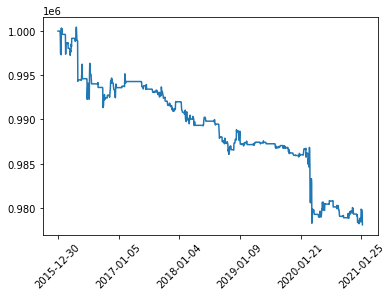

In [13]:
plot_returns(last_dates, last_portfolio_values)

In [14]:
"""
Variant 2 - Begin each trade on US market open (Evaluate after Asian market closes)

To open a position, we check the CLOSE price of adr of the previous row, compared to CLOSE px of 
stock of the current row. We buy the stock on the next trading OPEN for Asian/US market

To close a position, we check the CLOSE price of adr of the previous row, compared to CLOSE px of 
stock of the current row. We sell the stock on the next trading next OPEN for Asian/US market

For each row:
    stock_open, stock_close, (assess), adr_open, adr_close
    After first 2 events events, assess condition (right before the US market opens ~ 9.29AM EST)
    Place trade on current and next row (First trade ADR on US market open, then trade stock on Asian market open)
    
start_date: First date (EST) we may place a trade
end_date: Last date (EST) we may place a trade
portfolio_values: Stores value of portfolio at each date from one day before the start_date, to the end_date, when the Asian market opens
"""
def pairs_trade_v2(merged_df, lookback = 100, cash = 1000000, entry = 1, exit = 0, stop_loss = 3, 
                   start_date = "2016-01-01", end_date = "2021-01-31", slippage_bps = 10, 
                   borrowing_bps = 50, risk_lookback = 100, var_ci = 0.95, var_limit = 0.1, max_drawdown_limit = 0.2, 
                   sigma_limit = 0.05, maximum_holding_period = 30, volume_lookback = 5):
    
    # Accounts for slippage and transaction costs
    short_multiplier = 1 - 0.0001*slippage_bps
    long_multiplier = 1 + 0.0001*slippage_bps
    starting_cash = cash
    stock_pos, adr_pos = 0, 0
    holding_period = None
    forex_cash = 0
    diff_record = deque(maxlen = lookback)
    trade_records = []
    portfolio_values = []
    dates = []
    hits = []
    
    # Make sure that merged_df before end date is not empty
    if merged_df[merged_df['date'] < end_date].empty:
        return 0, trade_records, portfolio_values, hits, dates

    for index, row in merged_df.iterrows():
        
        if index+1 < len(merged_df) and index > 0:
            
            # Add portfolio value for the day before
            prev_date = merged_df.loc[index - 1, "date"]
            if row["date"] >= start_date and prev_date <= end_date:
                dates.append(prev_date)
                prev_forex_value = forex_cash + stock_pos*row["stock_open"]
                if prev_forex_value > 0:
                    prev_forex_value /= row['avg_ask_non_us_at']
                else:
                    prev_forex_value /= row['avg_bid_non_us_at']
                
                portfolio_values.append(cash + adr_pos*merged_df.loc[index - 1, 'adr_close'] 
                                        + prev_forex_value)

            diff_record.append(merged_df.loc[index-1,'adr_close_per_unit'] 
                                   - row['stock_close_per_unit']/row['avg_us_before'])
            
            # We place both trades the day itself
            if len(diff_record) < lookback or row["date"] < start_date or row["date"] > end_date:
                continue

            if stock_pos > 0:
                holding_period += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(adr_pos)*merged_df.loc[index - 1, 'adr_close']
                multiplier = (1 + 0.01*(2 + row["ir"])*(1/252))
                forex_cash *= multiplier
                
            mean = np.array(diff_record).mean()
            std = np.array(diff_record).std()
            
            # If we have passed the initial lookback window and are in the specified dates
            # enter the position if diff is significant
            if diff_record[-1] > mean + entry*std and diff_record[-1] <= mean + stop_loss*std:
                if stock_pos == 0 and adr_pos == 0:
                    portfolio_value_before_entering = cash
                    adr_volume = 0.2*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].median()/row["adr_num_per_unit"])
                    stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                    units = int(min(cash/merged_df.loc[index-1,'adr_close_per_unit'],
                                    cash/(row['stock_close_per_unit']/row['avg_us_before']), 
                                    adr_volume, 
                                    stock_volume))
                    adr_quantity = int(units*row["adr_num_per_unit"])
                    stock_quantity = int(units*row["stock_num_per_unit"])
                    # Take portfolio value for each previous day (till today) right before the US market opens
                    temp_risk_lookback = min(risk_lookback, index)
                    current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                    stock_values = np.array((current["stock_close"]/current["avg_us_before"])*stock_quantity) 
                    adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                    sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                    if (var > portfolio_value_before_entering*var_limit or 
                        max_drawdown_abs > max_drawdown_limit*starting_cash or 
                        sigma > portfolio_value_before_entering*sigma_limit):
                        frac = min((portfolio_value_before_entering*var_limit)/var, 
                                   (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                  (portfolio_value_before_entering*sigma_limit)/sigma)
                        units = int(frac*units)
                        if units == 0:
                            continue
                        adr_quantity = int(units*row["adr_num_per_unit"])
                        stock_quantity = int(units*row["stock_num_per_unit"])  
                    
                    adr_pos -= adr_quantity
                    adr_px = row['adr_open']*short_multiplier
                    cash += adr_quantity*adr_px
                    
                    stock_pos += stock_quantity
                    stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                    forex_cash -= stock_px_fx*stock_quantity
#                     stock_px = stock_px_fx/merged_df.loc[index+1,'avg_bid_non_us_at']
#                     cash -= stock_px*stock_quantity
                    
                    holding_period = 0
                    trade_records.append("Opening positions:\n")
                    # Times in EST
                    trade_records.append(f"We sold {adr_quantity} shares of ADR at the price of {adr_px} on {row['date']}\n")
                    trade_records.append(f"We bought {stock_quantity} shares of underlying stock at the price of {stock_px_fx} foreign dollars on {row['date']}\n")

            # Liquidation condition
            elif (diff_record[-1] < mean + exit*std or 
                  diff_record[-1] > mean + stop_loss*std or 
                  holding_period == maximum_holding_period):
                if stock_pos > 0 and adr_pos < 0 : 
                    adr_px = row['adr_open']*long_multiplier
                    cash -= abs(adr_pos)*adr_px
                    stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                    forex_cash += stock_px_fx*stock_pos
                    if forex_cash > 0:
                        forex_cash /= merged_df.loc[index+1,'avg_ask_non_us_at']
                    else:
                        forex_cash /= merged_df.loc[index+1,'avg_bid_non_us_at']
                    cash += forex_cash
                    forex_cash = 0
                    
                    trade_records.append("Closing positions:\n")
                    # Times in EST
                    trade_records.append(f"We bought {-adr_pos} shares of ADR at the price of {adr_px} on {row['date']}\n")
                    trade_records.append(f"We sold {stock_pos} shares of underlying stock at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                    stock_pos, adr_pos = 0, 0
                    holding_period = None
                    if cash > portfolio_value_before_entering:
                        hits.append(1)
                    else:
                        hits.append(0)

    ret = (portfolio_values[-1] - starting_cash)/starting_cash
    
    return ret, trade_records, portfolio_values, hits, dates

In [15]:
last_dates, last_portfolio_values = report_and_store_statistics(pairs_trade_v2, 'logs2.txt')

Country: Australia, ADR_Stock: ATHE_ATH, Return: 0.05%, Hit Ratio: 82.61%, Max Drawdown: 0.0%
Country: Australia, ADR_Stock: GENE_GTG, Return: 0.7%, Hit Ratio: 79.73%, Max Drawdown: 0.1%
Country: Australia, ADR_Stock: IMMP_IMM, Return: 0.3%, Hit Ratio: 82.93%, Max Drawdown: 0.33%
Country: Australia, ADR_Stock: IMRN_IMC, Return: 0.01%, Hit Ratio: 80.0%, Max Drawdown: 0.0%
Country: Australia, ADR_Stock: JHX_JHX, Return: 0.03%, Hit Ratio: 48.39%, Max Drawdown: 0.01%
Country: Australia, ADR_Stock: KZIA_KZA, Return: 0.06%, Hit Ratio: 72.88%, Max Drawdown: 0.09%
Country: Australia, ADR_Stock: MESO_MSB, Return: 0.55%, Hit Ratio: 76.19%, Max Drawdown: 0.74%
Country: Australia, ADR_Stock: PLL_PLL, Return: 4.71%, Hit Ratio: 80.0%, Max Drawdown: 1.06%
Country: Australia, ADR_Stock: WBK_WBC, Return: 0.19%, Hit Ratio: 51.04%, Max Drawdown: 0.25%
Country: China, ADR_Stock: ACH_2600, Return: 0.04%, Hit Ratio: 53.04%, Max Drawdown: 0.04%
Country: China, ADR_Stock: BGNE_6160, Return: 1.12%, Hit Ratio: 

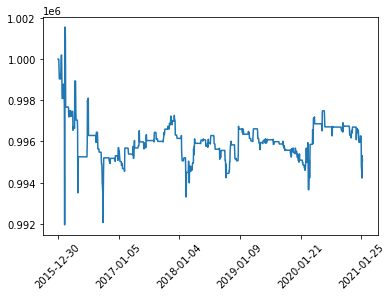

In [16]:
plot_returns(last_dates, last_portfolio_values)

In [17]:
"""
Variant 3a 
- Begin each trade on either US market open or Asian market open
- Regressions are done for the similar "type" of trade
    i.e. if we are entering at a certain time, we do a regression based on the values obtained at the same time each day

For each row:
    stock_open, stock_close, (assess condition 1), adr_open, adr_close, (assess condition 2)
    If not condition 2 - No action taken: 
        After first 2 events, Assess condition 1 (right before the US market opens ~ 9.29AM EST)
        If condition 1:
            Place trade on current and next row (First trade ADR on US market open, then trade stock on Asian market open)
    If not condition 1 - No action taken:
        After next 2 events occur, assess condition 2
        If condition 2:
            Place trade on next row (First trade ADR on Asian market open, then trade stock on US market open)
    
start_date: First date (EST) we may place a trade
end_date: Last date (EST) we may place a trade
portfolio_values: Stores value of portfolio at each date from one day before the start_date, to the end_date, when the Asian market opens
"""
def pairs_trade_v3a(merged_df, lookback = 100, cash = 1000000, entry_cond1_val = 1, entry_cond2_val = 1, 
                    exit_cond1_val = 0, exit_cond2_val = 0, stop_loss_cond1 = 3, stop_loss_cond2 = 3, 
                    start_date = "2016-01-01", end_date = "2021-01-31", slippage_bps = 10, 
                    borrowing_bps = 50, risk_lookback = 100, var_ci = 0.95, var_limit = 0.1, max_drawdown_limit = 0.2, 
                    sigma_limit = 0.05, maximum_holding_period = 30, volume_lookback = 5):

    # Accounts for slippage and transaction costs
    short_multiplier = 1 - 0.0001*slippage_bps
    long_multiplier = 1 + 0.0001*slippage_bps
    starting_cash = cash
    stock_pos, adr_pos = 0, 0
    holding_period = None
    trade_type = None
    forex_cash = 0
    # For book-keeping, since we shall store the portfolio value of the day before
    prev_cash, prev_adr_pos = cash, adr_pos
    diff_record_cond1 = deque(maxlen = lookback)
    diff_record_cond2 = deque(maxlen = lookback)
    trade_records = []
    portfolio_values = []
    dates = []
    hits = []
    enter_cond1, exit_cond1, enter_cond2, exit_cond2 = False, False, False, False
    
    # Make sure that merged_df before end date is not empty
    if merged_df[merged_df['date'] < end_date].empty:
        return 0, trade_records, portfolio_values, hits, dates
    
    for index, row in merged_df.iterrows():
                    
        if index+1 < len(merged_df) and index > 0:
            
            # Add portfolio value for the day before
            prev_date = merged_df.loc[index - 1, "date"]
            if row["date"] >= start_date and prev_date <= end_date:
                dates.append(prev_date)
                prev_forex_value = forex_cash + stock_pos*row["stock_open"]
                if prev_forex_value > 0:
                    prev_forex_value /= row['avg_ask_non_us_at']
                else:
                    prev_forex_value /= row['avg_bid_non_us_at']
                portfolio_values.append(prev_cash + prev_adr_pos*merged_df.loc[index - 1, 'adr_close'] 
                                        + prev_forex_value)
            
            # Before US Market Opens
            diff_record_cond1.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_us_before'])
            # Before Asian Market Opens
            diff_record_cond2.append(row['adr_close_per_unit'] 
                                   - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before'])


            # row["date"] is between start_date (inclusive) and end_date (inclusive)
            if len(diff_record_cond1) < lookback or row["date"] < start_date or row["date"] > end_date:
                continue

            # Update cash/adr position after portfolio values has been updated
            if stock_pos > 0:
                holding_period += 1
                cash -= 0.0001*borrowing_bps*(1/252)*abs(adr_pos)*merged_df.loc[index - 1, 'adr_close']
                multiplier = (1 + 0.01*(2 + row["ir"])*(1/252))
                forex_cash *= multiplier
            prev_cash, prev_adr_pos = cash, adr_pos
                
            mean_cond1 = np.array(diff_record_cond1).mean()
            std_cond1 = np.array(diff_record_cond1).std()
            mean_cond2 = np.array(diff_record_cond2).mean()
            std_cond2 = np.array(diff_record_cond2).std()
            
            # If a concurrent trade is not already being placed
            if not (enter_cond2 or exit_cond2):
                enter_cond1 = (diff_record_cond1[-1] > mean_cond1 + entry_cond1_val*std_cond1 
                               and diff_record_cond1[-1] <= mean_cond1 + stop_loss_cond1*std_cond1
                               and stock_pos == 0 and adr_pos == 0)
                exit_cond1 = ((diff_record_cond1[-1] < mean_cond1 + exit_cond1_val*std_cond1 
                              or diff_record_cond1[-1] > mean_cond1 + stop_loss_cond1*std_cond1
                              or (holding_period == maximum_holding_period and trade_type == 1))
                              and stock_pos > 0 and adr_pos < 0)
                    
                if enter_cond1:
                    portfolio_value_before_entering = cash
                    adr_volume = 0.2*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].median()/row["adr_num_per_unit"])
                    stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                    units = int(min(cash/row['adr_close_per_unit'],
                                    cash/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before']), 
                                    adr_volume, 
                                    stock_volume))
                    adr_quantity = int(units*row["adr_num_per_unit"])
                    stock_quantity = int(units*row["stock_num_per_unit"])
                    
                    # Take portfolio value for each previous day when the Asian market opens
                    temp_risk_lookback = min(risk_lookback, index)
                    current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                    stock_values = np.array((current["stock_close"]/current["avg_us_before"])*stock_quantity) 
                    adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                    sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                    if (var > portfolio_value_before_entering*var_limit or 
                        max_drawdown_abs > max_drawdown_limit*starting_cash or 
                        sigma > portfolio_value_before_entering*sigma_limit):
                        frac = min((portfolio_value_before_entering*var_limit)/var, 
                                   (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                  (portfolio_value_before_entering*sigma_limit)/sigma)
                        units = int(frac*units)
                        if units == 0:
                            enter_cond1 = False
                        adr_quantity = int(units*row["adr_num_per_unit"])
                        stock_quantity = int(units*row["stock_num_per_unit"])
                    if units != 0:
                                
                        adr_pos -= adr_quantity
                        adr_px = row['adr_open']*short_multiplier
                        cash += adr_quantity*adr_px

                        stock_pos += stock_quantity
                        stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                        forex_cash -= stock_px_fx*stock_quantity
                        prev_cash, prev_adr_pos = cash, adr_pos
                        holding_period = 0
                        trade_type = 1
                        
                        trade_records.append("Opening positions:\n")
                        # Times in EST
                        trade_records.append(f"We sold {adr_quantity} shares of ADR at the price of {adr_px} on {row['date']}\n")
                        trade_records.append(f"We bought {stock_quantity} shares of underlying stock at the price of {stock_px_fx} foreign dollars on {row['date']}\n")

                elif exit_cond1:
                    
                    adr_px = row['adr_open']*long_multiplier
                    cash -= abs(adr_pos)*adr_px
                    stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                    forex_cash += stock_px_fx*stock_pos
                    if forex_cash > 0:
                        forex_cash /= merged_df.loc[index+1,'avg_ask_non_us_at']
                    else:
                        forex_cash /= merged_df.loc[index+1,'avg_bid_non_us_at']
                    cash += forex_cash
                    forex_cash = 0
                    trade_records.append("Closing positions:\n")
                    # Times in EST
                    trade_records.append(f"We bought {-adr_pos} shares of ADR at the price of {adr_px} on {row['date']}\n")
                    trade_records.append(f"We sold {stock_pos} shares of underlying stock at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                    stock_pos, adr_pos = 0, 0
                    holding_period = None
                    trade_type = None
                    prev_cash, prev_adr_pos = cash, adr_pos
                    if cash > portfolio_value_before_entering:
                        hits.append(1)
                    else:
                        hits.append(0)
                    
            # If a concurrent trade is not already being placed
            # The 2nd trade of condition 2 falls on the next day
            if not (enter_cond1 or exit_cond1) and merged_df.loc[index+1, "date"] <= end_date:
                # Check and possibly trade condition 2
                enter_cond2 = (diff_record_cond2[-1] > mean_cond2 + entry_cond2_val*std_cond2 
                               and diff_record_cond2[-1] <= mean_cond2 + stop_loss_cond2*std_cond2
                               and stock_pos == 0 and adr_pos == 0)
                exit_cond2 = ((diff_record_cond2[-1] < mean_cond2 + exit_cond2_val*std_cond2 
                              or diff_record_cond2[-1] > mean_cond2 + stop_loss_cond2*std_cond2
                              or (holding_period == maximum_holding_period and trade_type == 2))
                              and stock_pos > 0 and adr_pos < 0)
                    
                if enter_cond2:
                    portfolio_value_before_entering = cash
                    adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].median()/row["adr_num_per_unit"])
                    stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                    units = int(min(cash/merged_df.loc[index-1,'adr_close_per_unit'],
                                    cash/(row['stock_close_per_unit']/row['avg_us_before']), 
                                    adr_volume, 
                                    stock_volume))
                    adr_quantity = int(units*row["adr_num_per_unit"])
                    stock_quantity = int(units*row["stock_num_per_unit"])
                    
                    # Take portfolio value for each previous day when the Asian market opens
                    temp_risk_lookback = min(risk_lookback, index)
                    current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                    next_day = merged_df.loc[(index - temp_risk_lookback + 2):(index + 1)].copy()
                    stock_values = (np.array((current["stock_close"])/np.array(next_day["avg_non_us_before"]))*stock_quantity) 
                    adr_values = np.array(current["adr_close"]*adr_quantity)
                    sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                    if (var > portfolio_value_before_entering*var_limit or 
                        max_drawdown_abs > max_drawdown_limit*starting_cash or 
                        sigma > portfolio_value_before_entering*sigma_limit):
                        frac = min((portfolio_value_before_entering*var_limit)/var, 
                                   (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                  (portfolio_value_before_entering*sigma_limit)/sigma)
                        units = int(frac*units)
                        if units == 0:
                            enter_cond2 = False
                        adr_quantity = int(units*row["adr_num_per_unit"])
                        stock_quantity = int(units*row["stock_num_per_unit"]) 
                    if units != 0:
                        stock_pos += stock_quantity
                        stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                        forex_cash -= stock_px_fx*stock_quantity
                        # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                        prev_cash, prev_adr_pos = cash, adr_pos
                        
                        adr_pos -= adr_quantity
                        adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                        cash += adr_quantity*adr_px
                        
                        holding_period = 0
                        trade_type = 2
                        trade_records.append("Opening positions:\n")
                        # Times in EST
                        trade_records.append(f"We bought {stock_quantity} shares of underlying stock at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                        trade_records.append(f"We sold {adr_quantity} shares of ADR at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                elif exit_cond2:
                    stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                    forex_cash += stock_px_fx*stock_pos
                    if forex_cash > 0:
                        forex_cash /= merged_df.loc[index+1,'avg_ask_non_us_at']
                    else:
                        forex_cash /= merged_df.loc[index+1,'avg_bid_non_us_at']
                    cash += forex_cash
                    forex_cash = 0
                    # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                    prev_cash, prev_adr_pos = cash, adr_pos
                    
                    adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                    cash -= abs(adr_pos)*adr_px
                    trade_records.append("Closing positions:\n")
                    # Times in EST
                    trade_records.append(f"We sold {stock_pos} shares of underlying stock at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                    trade_records.append(f"We bought {-adr_pos} shares of ADR at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")
                    stock_pos, adr_pos = 0, 0
                    holding_period = None
                    trade_type = None
                    if cash > portfolio_value_before_entering:
                        hits.append(1)
                    else:
                        hits.append(0)

    ret = (portfolio_values[-1] - starting_cash)/starting_cash

    return ret, trade_records, portfolio_values, hits, dates

In [18]:
last_dates, last_portfolio_values = report_and_store_statistics(pairs_trade_v3a, 'logs3a.txt')

Country: Australia, ADR_Stock: ATHE_ATH, Return: 0.05%, Hit Ratio: 85.0%, Max Drawdown: 0.01%
Country: Australia, ADR_Stock: GENE_GTG, Return: 0.96%, Hit Ratio: 79.07%, Max Drawdown: 0.68%
Country: Australia, ADR_Stock: IMMP_IMM, Return: 0.36%, Hit Ratio: 75.44%, Max Drawdown: 0.05%
Country: Australia, ADR_Stock: IMRN_IMC, Return: 0.28%, Hit Ratio: 80.0%, Max Drawdown: 0.01%
Country: Australia, ADR_Stock: JHX_JHX, Return: 0.05%, Hit Ratio: 44.16%, Max Drawdown: 0.02%
Country: Australia, ADR_Stock: KZIA_KZA, Return: 0.21%, Hit Ratio: 69.57%, Max Drawdown: 0.09%
Country: Australia, ADR_Stock: MESO_MSB, Return: 0.55%, Hit Ratio: 82.91%, Max Drawdown: 0.67%
Country: Australia, ADR_Stock: PLL_PLL, Return: 4.37%, Hit Ratio: 75.76%, Max Drawdown: 2.27%
Country: Australia, ADR_Stock: WBK_WBC, Return: -0.06%, Hit Ratio: 47.71%, Max Drawdown: 0.43%
Country: China, ADR_Stock: ACH_2600, Return: 0.02%, Hit Ratio: 52.07%, Max Drawdown: 0.04%
Country: China, ADR_Stock: BGNE_6160, Return: 5.47%, Hit R

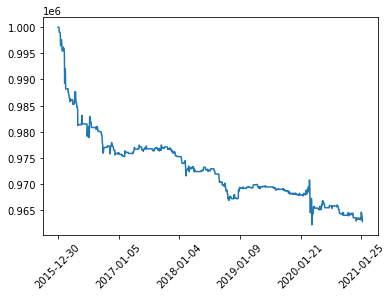

In [19]:
plot_returns(last_dates, last_portfolio_values)

In [20]:
"""
Variant 3b
- Begin each trade on either US market open or Asian market open
- Regressions are done for all data collected in lookback window

For each row:
    stock_open, stock_close, (assess condition 1), adr_open, adr_close, (assess condition 2)
    If not condition 2 - No action taken: 
        After first 2 events, Assess condition 1 (right before the US market opens ~ 9.29AM EST)
        If condition 1:
            Place trade on current and next row (First trade ADR on US market open, then trade stock on Asian market open)
    If not condition 1 - No action taken:
        After next 2 events occur, assess condition 2
        If condition 2:
            Place trade on next row (First trade ADR on Asian market open, then trade stock on US market open)
    
start_date: First date (EST) we may place a trade
end_date: Last date (EST) we may place a trade
portfolio_values: Stores value of portfolio at each date from one day before the start_date, to the end_date, when the Asian market opens
"""
def pairs_trade_v3b(merged_df, lookback = 100, cash = 1000000, entry_cond1_val = 1, entry_cond2_val = 1, 
                    exit_cond1_val = 0, exit_cond2_val = 0, stop_loss_cond1 = 3, stop_loss_cond2 = 3, 
                    start_date = "2016-01-01", end_date = "2021-01-31", slippage_bps = 10, 
                    borrowing_bps = 50, risk_lookback = 100, var_ci = 0.95, var_limit = 0.1, max_drawdown_limit = 0.2,
                    sigma_limit = 0.05, maximum_holding_period = 30, volume_lookback = 5):
    
    # Accounts for slippage and transaction costs
    short_multiplier = 1 - 0.0001*slippage_bps
    long_multiplier = 1 + 0.0001*slippage_bps
    # We assume lookback is given in terms of days
    lookback *= 2
    starting_cash = cash
    stock_pos, adr_pos = 0, 0
    holding_period = None
    trade_type = None
    forex_cash = 0
    # For book-keeping, since we shall store the portfolio value of the day before
    prev_cash, prev_adr_pos = cash, adr_pos
    diff_record = deque(maxlen = lookback)
    trade_records = []
    portfolio_values = []
    dates = []
    hits = []
    enter_cond1, exit_cond1, enter_cond2, exit_cond2 = False, False, False, False
    
    # Make sure that merged_df before end date is not empty
    if merged_df[merged_df['date'] < end_date].empty:
        return 0, trade_records, portfolio_values, hits, dates

    for index, row in merged_df.iterrows():

        if index+1 < len(merged_df) and index > 0:
            
            # Add portfolio value for the day before
            prev_date = merged_df.loc[index - 1, "date"]
            if row["date"] >= start_date and prev_date <= end_date:
                dates.append(prev_date)
                prev_forex_value = forex_cash + stock_pos*row["stock_open"]
                if prev_forex_value > 0:
                    prev_forex_value /= row['avg_ask_non_us_at']
                else:
                    prev_forex_value /= row['avg_bid_non_us_at']
                
                portfolio_values.append(prev_cash + prev_adr_pos*merged_df.loc[index - 1, 'adr_close'] 
                                        + prev_forex_value)
                
            # Before US Market Opens
            diff_record.append(merged_df.loc[index-1,'adr_close_per_unit'] - row['stock_close_per_unit']/row['avg_us_before'])
            if len(diff_record) == lookback and row["date"] >= start_date and row["date"] <= end_date:
                if stock_pos > 0:
                    holding_period += 1
                    cash -= 0.0001*borrowing_bps*(1/252)*abs(adr_pos)*merged_df.loc[index - 1, 'adr_close']
                    multiplier = (1 + 0.01*(2 + row["ir"])*(1/252))
                    forex_cash *= multiplier
                prev_cash, prev_adr_pos = cash, adr_pos
                    
                mean = np.array(diff_record).mean()
                std = np.array(diff_record).std()
                
                # If a concurrent trade is not already being placed
                if not (enter_cond2 or exit_cond2):
                    enter_cond1 = (diff_record[-1] > mean + entry_cond1_val*std
                                   and diff_record[-1] <= mean + stop_loss_cond1*std
                                   and stock_pos == 0 and adr_pos == 0)
                    exit_cond1 = ((diff_record[-1] < mean + exit_cond1_val*std
                                  or diff_record[-1] > mean + stop_loss_cond1*std
                                  or (holding_period == maximum_holding_period and trade_type == 1))
                                  and stock_pos > 0 and adr_pos < 0)
                    
                    if enter_cond1:
                        portfolio_value_before_entering = cash
                        adr_volume = 0.2*(merged_df.loc[index-volume_lookback:index - 1,:]["adr_volume"].median()/row["adr_num_per_unit"])
                        stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                        units = int(min(cash/row['adr_close_per_unit'],
                                        cash/(row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before']), 
                                        adr_volume, 
                                        stock_volume))
                        adr_quantity = int(units*row["adr_num_per_unit"])
                        stock_quantity = int(units*row["stock_num_per_unit"])
                        
                        temp_risk_lookback = min(risk_lookback, index)
                        current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                        stock_values = np.array((current["stock_close"]/current["avg_us_before"])*stock_quantity) 
                        adr_values = np.array(merged_df.loc[(index - temp_risk_lookback):(index-1)]["adr_close"]*adr_quantity)
                        sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                        if (var > portfolio_value_before_entering*var_limit or 
                            max_drawdown_abs > max_drawdown_limit*starting_cash or 
                            sigma > portfolio_value_before_entering*sigma_limit):
                            frac = min((portfolio_value_before_entering*var_limit)/var, 
                                       (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                      (portfolio_value_before_entering*sigma_limit)/sigma)
                            units = int(frac*units)
                            if units == 0:
                                enter_cond1 = False
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"]) 
                        if units != 0:
                            adr_pos -= adr_quantity
                            adr_px = row['adr_open']*short_multiplier
                            cash += adr_quantity*adr_px

                            stock_pos += stock_quantity
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                            forex_cash -= stock_px_fx*stock_quantity
                            prev_cash, prev_adr_pos = cash, adr_pos
                            holding_period = 0
                            trade_type = 1
                            trade_records.append("Opening positions:\n")
                            # Times in EST
                            trade_records.append(f"We sold {adr_quantity} shares of ADR at the price of {adr_px} on {row['date']}\n")
                            trade_records.append(f"We bought {stock_quantity} shares of underlying stock at the price of {stock_px_fx} foreign dollars on {row['date']}\n")

                    elif exit_cond1:

                        adr_px = row['adr_open']*long_multiplier
                        cash -= abs(adr_pos)*adr_px
                        stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                        forex_cash += stock_px_fx*stock_pos
                        if forex_cash > 0:
                            forex_cash /= merged_df.loc[index+1,'avg_ask_non_us_at']
                        else:
                            forex_cash /= merged_df.loc[index+1,'avg_bid_non_us_at']
                        cash += forex_cash
                        forex_cash = 0
                        trade_records.append("Closing positions:\n")
                        # Times in EST
                        trade_records.append(f"We bought {-adr_pos} shares of ADR at the price of {adr_px} on {row['date']}\n")
                        trade_records.append(f"We sold {stock_pos} shares of underlying stock at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                        stock_pos, adr_pos = 0, 0
                        holding_period = None
                        trade_type = None
                        prev_cash, prev_adr_pos = cash, adr_pos
                        if cash > portfolio_value_before_entering:
                            hits.append(1)
                        else:
                            hits.append(0)
                        
            # Before Asian Market Opens
            diff_record.append(row['adr_close_per_unit'] - row['stock_close_per_unit']/merged_df.loc[index+1,'avg_non_us_before'])
            # The 2nd trade of condition 2 falls on the next day
            if len(diff_record) == lookback and row["date"] >= start_date and merged_df.loc[index+1,"date"] <= end_date:
                mean = np.array(diff_record).mean()
                std = np.array(diff_record).std()
                # If a concurrent trade is not already being placed
                if not (enter_cond1 or exit_cond1):
                    enter_cond2 = (diff_record[-1] > mean + entry_cond2_val*std
                                   and diff_record[-1] <= mean + stop_loss_cond2*std
                                   and stock_pos == 0 and adr_pos == 0)
                    exit_cond2 = ((diff_record[-1] < mean + exit_cond2_val*std
                                  or diff_record[-1] > mean + stop_loss_cond2*std
                                  or (holding_period == maximum_holding_period and trade_type == 2))
                                  and stock_pos > 0 and adr_pos < 0)

                    if enter_cond2:
                        portfolio_value_before_entering = cash
                        adr_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["adr_volume"].median()/row["adr_num_per_unit"])
                        stock_volume = 0.2*(merged_df.loc[index-volume_lookback+1:index,:]["stock_volume"].median()/row["stock_num_per_unit"])
                        units = int(min(cash/merged_df.loc[index-1,'adr_close_per_unit'],
                                        cash/(row['stock_close_per_unit']/row['avg_us_before']), 
                                        adr_volume, 
                                        stock_volume))
                        adr_quantity = int(units*row["adr_num_per_unit"])
                        stock_quantity = int(units*row["stock_num_per_unit"])
                        temp_risk_lookback = min(risk_lookback, index)
                        current = merged_df.loc[(index - temp_risk_lookback + 1):index].copy()
                        next_day = merged_df.loc[(index - temp_risk_lookback + 2):(index + 1)].copy()
                        stock_values = (np.array((current["stock_close"])/np.array(next_day["avg_non_us_before"]))*stock_quantity) 
                        adr_values = np.array(current["adr_close"]*adr_quantity)
                        sigma, var, max_drawdown_abs = get_risk_statistics(stock_values, adr_values, var_ci)
                        if (var > portfolio_value_before_entering*var_limit or 
                            max_drawdown_abs > max_drawdown_limit*starting_cash or 
                            sigma > portfolio_value_before_entering*sigma_limit):
                            frac = min((portfolio_value_before_entering*var_limit)/var, 
                                       (max_drawdown_limit*starting_cash)/max_drawdown_abs,
                                      (portfolio_value_before_entering*sigma_limit)/sigma)
                            units = int(frac*units)
                            if units == 0:
                                enter_cond2 = False
                            adr_quantity = int(units*row["adr_num_per_unit"])
                            stock_quantity = int(units*row["stock_num_per_unit"])  
                        if units != 0:
                            stock_pos += stock_quantity
                            stock_px_fx = merged_df.loc[index+1,'stock_open']*long_multiplier
                            forex_cash -= stock_px_fx*stock_quantity
                            # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                            prev_cash, prev_adr_pos = cash, adr_pos

                            adr_pos -= adr_quantity
                            adr_px = merged_df.loc[index+1,'adr_open']*short_multiplier
                            cash += adr_quantity*adr_px
                            holding_period = 0
                            trade_type = 2
                            trade_records.append("Opening positions:\n")
                            # Times in EST
                            trade_records.append(f"We bought {stock_quantity} shares of underlying stock at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                            trade_records.append(f"We sold {adr_quantity} shares of ADR at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")

                    elif exit_cond2:
                        stock_px_fx = merged_df.loc[index+1,'stock_open']*short_multiplier
                        forex_cash += stock_px_fx*stock_pos
                        if forex_cash > 0:
                            forex_cash /= merged_df.loc[index+1,'avg_ask_non_us_at']
                        else:
                            forex_cash /= merged_df.loc[index+1,'avg_bid_non_us_at']
                        cash += forex_cash
                        forex_cash = 0
                        # We store the current cash/adr position, because the trade below will occur on the next day (EST)
                        prev_cash, prev_adr_pos = cash, adr_pos
                        
                        adr_px = merged_df.loc[index+1,'adr_open']*long_multiplier
                        cash -= abs(adr_pos)*adr_px
                        trade_records.append("Closing positions:\n")
                        # Times in EST
                        trade_records.append(f"We sold {stock_pos} shares of underlying stock at the price of {stock_px_fx} foreign dollars on {row['date']}\n")
                        trade_records.append(f"We bought {-adr_pos} shares of ADR at the price of {adr_px} on {merged_df.loc[index+1,'date']}\n")
                        stock_pos, adr_pos = 0, 0
                        holding_period = None
                        trade_type = None
                        if cash > portfolio_value_before_entering:
                            hits.append(1)
                        else:
                            hits.append(0)

    ret = (portfolio_values[-1] - starting_cash)/starting_cash

    return ret, trade_records, portfolio_values, hits, dates

In [ ]:
last_dates, last_portfolio_values = report_and_store_statistics(pairs_trade_v3b, 'logs3b.txt')

Country: Australia, ADR_Stock: ATHE_ATH, Return: 0.04%, Hit Ratio: 87.72%, Max Drawdown: 0.01%
Country: Australia, ADR_Stock: GENE_GTG, Return: 0.96%, Hit Ratio: 82.5%, Max Drawdown: 0.68%
Country: Australia, ADR_Stock: IMMP_IMM, Return: 0.23%, Hit Ratio: 75.0%, Max Drawdown: 0.02%
Country: Australia, ADR_Stock: IMRN_IMC, Return: 0.28%, Hit Ratio: 80.43%, Max Drawdown: 0.0%
Country: Australia, ADR_Stock: JHX_JHX, Return: 0.03%, Hit Ratio: 43.05%, Max Drawdown: 0.04%
Country: Australia, ADR_Stock: KZIA_KZA, Return: 0.44%, Hit Ratio: 70.79%, Max Drawdown: 0.02%
Country: Australia, ADR_Stock: MESO_MSB, Return: 0.56%, Hit Ratio: 80.83%, Max Drawdown: 0.67%
Country: Australia, ADR_Stock: PLL_PLL, Return: 4.94%, Hit Ratio: 72.31%, Max Drawdown: 5.14%
Country: Australia, ADR_Stock: WBK_WBC, Return: 0.15%, Hit Ratio: 48.91%, Max Drawdown: 0.27%
Country: China, ADR_Stock: ACH_2600, Return: -0.05%, Hit Ratio: 52.17%, Max Drawdown: 0.09%
Country: China, ADR_Stock: BGNE_6160, Return: 6.92%, Hit Ra

In [ ]:
plot_returns(last_dates, last_portfolio_values)